Khởi tạo datasets

In [1]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import random

def augment_hsv(im, hgain= 0, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


# Change cv2.resize to import data correctly

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, width, height):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.width, self.height = width, height

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index])
        image = cv2.resize(image, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
        augment_hsv(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0 ## (512, 512, 3)
        
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        
        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
        # mask = mask/255.0   ## (512, 512)
        mask = cv2.resize(mask, (160, 80), interpolation=cv2.INTER_LINEAR)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        
        mask = np.where(mask != 0, 1.0, 0.0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask
    def __len__(self):
        return self.n_samples
    

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



/data/hoangtv/data/AIChallenge/anaconda3/envs/cds/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Khởi tạo hàm loss và hàm tính mIoU

In [8]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F



class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
    

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold = 0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = torch.sigmoid(outputs)
    outputs = (outputs> threshold)
    outputs = outputs.to(dtype=torch.int8)

    labels = labels.to(dtype=torch.int8)
    # print(outputs)
    intersection = (outputs & labels).float().sum((1, 2, 3))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2, 3))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # print(sum(iou)/outputs.shape[0])
    return sum(iou)/outputs.shape[0]  # Or thresholded.mean() if you are interested in average across the batch



Khởi tạo mô hình Unet

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, group=out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


Dataset Size:
Train: 500 - Valid: 200

Epoch: 1
Train...


100%|██████████| 125/125 [00:09<00:00, 13.36it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 39.10it/s]

tensor(0.7372, device='cuda:0')
tensor(0.7535, device='cuda:0')
tensor(0.6536, device='cuda:0')
tensor(0.7471, device='cuda:0')
tensor(0.5841, device='cuda:0')
tensor(0.6881, device='cuda:0')
tensor(0.7488, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 39.34it/s]

tensor(0.4517, device='cuda:0')
tensor(0.5927, device='cuda:0')


 26%|██▌       | 13/50 [00:00<00:00, 40.12it/s]

tensor(0.6647, device='cuda:0')
tensor(0.6778, device='cuda:0')
tensor(0.4096, device='cuda:0')
tensor(0.3968, device='cuda:0')
tensor(0.2926, device='cuda:0')
tensor(0.3857, device='cuda:0')
tensor(0.4027, device='cuda:0')


 36%|███▌      | 18/50 [00:00<00:00, 40.43it/s]

tensor(0.7054, device='cuda:0')
tensor(0.7169, device='cuda:0')


 46%|████▌     | 23/50 [00:00<00:00, 40.62it/s]

tensor(0.6147, device='cuda:0')
tensor(0.5166, device='cuda:0')
tensor(0.8156, device='cuda:0')
tensor(0.8534, device='cuda:0')
tensor(0.6652, device='cuda:0')
tensor(0.5533, device='cuda:0')
tensor(0.6054, device='cuda:0')
tensor(0.7240, device='cuda:0')
tensor(0.7535, device='cuda:0')


 66%|██████▌   | 33/50 [00:00<00:00, 40.42it/s]

tensor(0.8038, device='cuda:0')
tensor(0.7288, device='cuda:0')
tensor(0.6523, device='cuda:0')
tensor(0.7629, device='cuda:0')
tensor(0.8265, device='cuda:0')
tensor(0.7411, device='cuda:0')
tensor(0.7705, device='cuda:0')
tensor(0.7353, device='cuda:0')
tensor(0.7573, device='cuda:0')


 86%|████████▌ | 43/50 [00:01<00:00, 40.28it/s]

tensor(0.6146, device='cuda:0')
tensor(0.4424, device='cuda:0')
tensor(0.4947, device='cuda:0')
tensor(0.4697, device='cuda:0')
tensor(0.7944, device='cuda:0')
tensor(0.7972, device='cuda:0')
tensor(0.8337, device='cuda:0')
tensor(0.8338, device='cuda:0')
tensor(0.8368, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 40.34it/s]


tensor(0.9068, device='cuda:0')
tensor(0.7491, device='cuda:0')
tensor(0.8702, device='cuda:0')
tensor(0.9173, device='cuda:0')
tensor(0.8872, device='cuda:0')
Mean IoU: 0.6787
Valid loss improved from inf to 0.4360. Saving checkpoint: ./best.pth
	Train Loss: 0.480
	 Val. Loss: 0.436



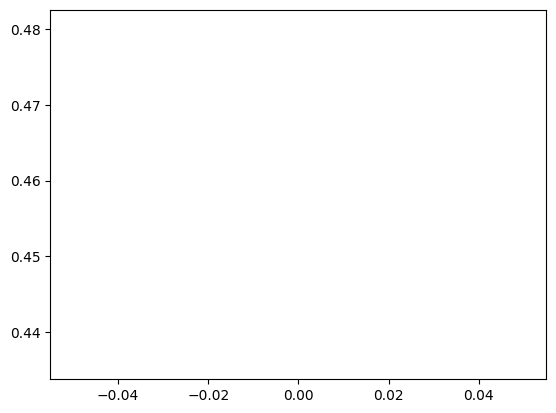

Epoch: 2
Train...


100%|██████████| 125/125 [00:09<00:00, 13.51it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.56it/s]

tensor(0.7971, device='cuda:0')
tensor(0.7769, device='cuda:0')
tensor(0.7287, device='cuda:0')
tensor(0.7839, device='cuda:0')
tensor(0.6332, device='cuda:0')
tensor(0.7111, device='cuda:0')
tensor(0.7852, device='cuda:0')
tensor(0.5768, device='cuda:0')
tensor(0.7265, device='cuda:0')


 30%|███       | 15/50 [00:00<00:00, 40.79it/s]

tensor(0.6795, device='cuda:0')
tensor(0.7078, device='cuda:0')
tensor(0.5048, device='cuda:0')
tensor(0.4184, device='cuda:0')
tensor(0.3565, device='cuda:0')
tensor(0.4043, device='cuda:0')
tensor(0.4408, device='cuda:0')
tensor(0.7525, device='cuda:0')
tensor(0.7559, device='cuda:0')


 50%|█████     | 25/50 [00:00<00:00, 40.62it/s]

tensor(0.6241, device='cuda:0')
tensor(0.5832, device='cuda:0')
tensor(0.8734, device='cuda:0')
tensor(0.9150, device='cuda:0')
tensor(0.6921, device='cuda:0')
tensor(0.5711, device='cuda:0')
tensor(0.6627, device='cuda:0')
tensor(0.8802, device='cuda:0')
tensor(0.8405, device='cuda:0')


 70%|███████   | 35/50 [00:00<00:00, 40.35it/s]

tensor(0.8712, device='cuda:0')
tensor(0.8693, device='cuda:0')
tensor(0.6721, device='cuda:0')
tensor(0.7754, device='cuda:0')
tensor(0.8472, device='cuda:0')
tensor(0.7833, device='cuda:0')
tensor(0.7927, device='cuda:0')
tensor(0.7595, device='cuda:0')
tensor(0.7913, device='cuda:0')


 80%|████████  | 40/50 [00:00<00:00, 40.33it/s]

tensor(0.8930, device='cuda:0')
tensor(0.5193, device='cuda:0')
tensor(0.5806, device='cuda:0')
tensor(0.4950, device='cuda:0')
tensor(0.8052, device='cuda:0')
tensor(0.7901, device='cuda:0')
tensor(0.8475, device='cuda:0')
tensor(0.9049, device='cuda:0')


 90%|█████████ | 45/50 [00:01<00:00, 40.25it/s]

tensor(0.8585, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 40.41it/s]

tensor(0.9155, device='cuda:0')
tensor(0.7561, device='cuda:0')
tensor(0.9137, device='cuda:0')
tensor(0.8574, device='cuda:0')
tensor(0.9141, device='cuda:0')
Mean IoU: 0.7279
Valid loss improved from 0.4360 to 0.2536. Saving checkpoint: ./best.pth


	Train Loss: 0.279
	 Val. Loss: 0.254



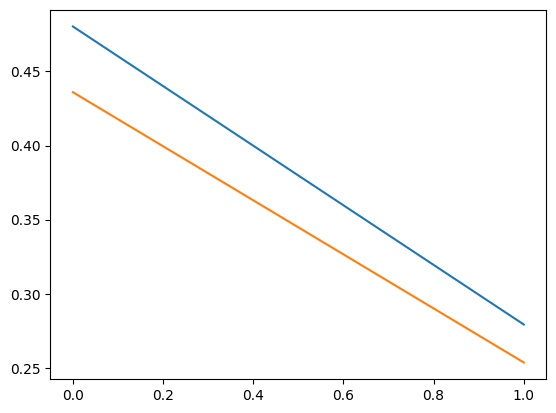

Epoch: 3
Train...


100%|██████████| 125/125 [00:09<00:00, 13.45it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.36it/s]

tensor(0.7962, device='cuda:0')
tensor(0.7745, device='cuda:0')
tensor(0.7259, device='cuda:0')
tensor(0.7871, device='cuda:0')
tensor(0.6349, device='cuda:0')
tensor(0.7106, device='cuda:0')
tensor(0.7885, device='cuda:0')
tensor(0.5794, device='cuda:0')
tensor(0.7292, device='cuda:0')


 30%|███       | 15/50 [00:00<00:00, 40.49it/s]

tensor(0.6825, device='cuda:0')
tensor(0.7079, device='cuda:0')
tensor(0.5168, device='cuda:0')
tensor(0.4184, device='cuda:0')
tensor(0.3584, device='cuda:0')
tensor(0.3657, device='cuda:0')
tensor(0.4620, device='cuda:0')
tensor(0.7305, device='cuda:0')
tensor(0.7575, device='cuda:0')


 50%|█████     | 25/50 [00:00<00:00, 40.66it/s]

tensor(0.6298, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.8734, device='cuda:0')
tensor(0.9147, device='cuda:0')
tensor(0.6921, device='cuda:0')
tensor(0.5749, device='cuda:0')
tensor(0.6630, device='cuda:0')
tensor(0.8806, device='cuda:0')
tensor(0.8339, device='cuda:0')


 70%|███████   | 35/50 [00:00<00:00, 40.54it/s]

tensor(0.8749, device='cuda:0')
tensor(0.8703, device='cuda:0')
tensor(0.6594, device='cuda:0')
tensor(0.7703, device='cuda:0')
tensor(0.8361, device='cuda:0')
tensor(0.7916, device='cuda:0')
tensor(0.7995, device='cuda:0')
tensor(0.7607, device='cuda:0')
tensor(0.7914, device='cuda:0')


 80%|████████  | 40/50 [00:00<00:00, 40.31it/s]

tensor(0.9031, device='cuda:0')
tensor(0.4634, device='cuda:0')
tensor(0.5829, device='cuda:0')
tensor(0.4953, device='cuda:0')
tensor(0.8215, device='cuda:0')
tensor(0.8135, device='cuda:0')
tensor(0.8490, device='cuda:0')
tensor(0.8906, device='cuda:0')


 90%|█████████ | 45/50 [00:01<00:00, 40.10it/s]

tensor(0.8586, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 40.34it/s]

tensor(0.9171, device='cuda:0')
tensor(0.8045, device='cuda:0')
tensor(0.9102, device='cuda:0')
tensor(0.9352, device='cuda:0')
tensor(0.9173, device='cuda:0')
Mean IoU: 0.7298
Valid loss improved from 0.2536 to 0.2231. Saving checkpoint: ./best.pth


	Train Loss: 0.243
	 Val. Loss: 0.223



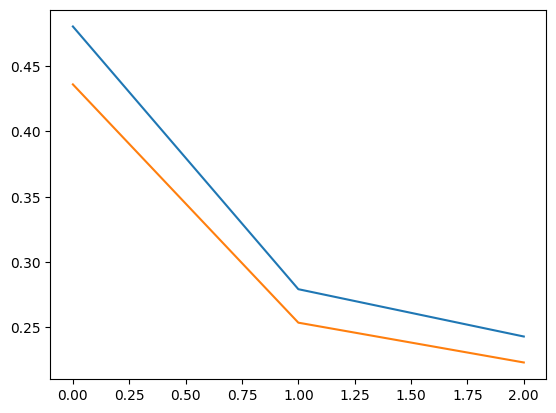

Epoch: 4
Train...


100%|██████████| 125/125 [00:09<00:00, 13.44it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 39.16it/s]

tensor(0.7955, device='cuda:0')
tensor(0.6176, device='cuda:0')
tensor(0.7033, device='cuda:0')
tensor(0.7830, device='cuda:0')
tensor(0.6353, device='cuda:0')
tensor(0.7124, device='cuda:0')
tensor(0.7886, device='cuda:0')


 18%|█▊        | 9/50 [00:00<00:01, 39.97it/s]

tensor(0.5789, device='cuda:0')
tensor(0.7280, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 40.16it/s]

tensor(0.6848, device='cuda:0')
tensor(0.7098, device='cuda:0')
tensor(0.5182, device='cuda:0')
tensor(0.3877, device='cuda:0')
tensor(0.3587, device='cuda:0')
tensor(0.4124, device='cuda:0')
tensor(0.4383, device='cuda:0')
tensor(0.7655, device='cuda:0')
tensor(0.5790, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 40.38it/s]

tensor(0.6259, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.8743, device='cuda:0')
tensor(0.9131, device='cuda:0')
tensor(0.6938, device='cuda:0')
tensor(0.4506, device='cuda:0')
tensor(0.6649, device='cuda:0')
tensor(0.8806, device='cuda:0')
tensor(0.6485, device='cuda:0')


 68%|██████▊   | 34/50 [00:00<00:00, 40.11it/s]

tensor(0.8595, device='cuda:0')
tensor(0.8743, device='cuda:0')
tensor(0.6699, device='cuda:0')
tensor(0.7708, device='cuda:0')
tensor(0.8509, device='cuda:0')
tensor(0.8003, device='cuda:0')
tensor(0.8050, device='cuda:0')
tensor(0.7606, device='cuda:0')
tensor(0.7754, device='cuda:0')


 78%|███████▊  | 39/50 [00:00<00:00, 40.08it/s]

tensor(0.8982, device='cuda:0')
tensor(0.4896, device='cuda:0')
tensor(0.5707, device='cuda:0')
tensor(0.4972, device='cuda:0')
tensor(0.6547, device='cuda:0')
tensor(0.7099, device='cuda:0')
tensor(0.6714, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 40.06it/s]

tensor(0.8006, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 40.08it/s]

tensor(0.8343, device='cuda:0')
tensor(0.7600, device='cuda:0')
tensor(0.1942, device='cuda:0')
tensor(0.2403, device='cuda:0')
tensor(0.7196, device='cuda:0')
tensor(0.7481, device='cuda:0')
Mean IoU: 0.6698
	Train Loss: 0.174
	 Val. Loss: 0.339



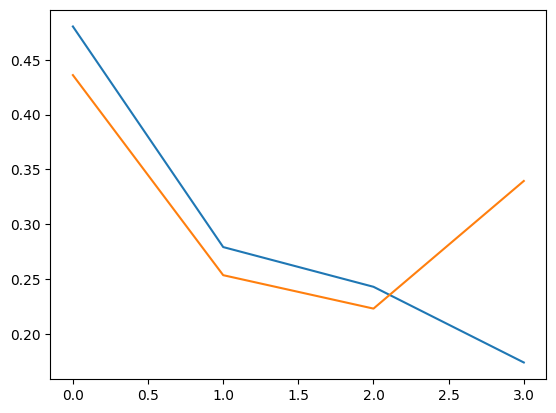

Epoch: 5
Train...


100%|██████████| 125/125 [00:09<00:00, 13.40it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 41.01it/s]

tensor(0.7896, device='cuda:0')
tensor(0.7776, device='cuda:0')
tensor(0.7288, device='cuda:0')
tensor(0.7868, device='cuda:0')
tensor(0.6442, device='cuda:0')
tensor(0.7172, device='cuda:0')
tensor(0.7892, device='cuda:0')
tensor(0.5805, device='cuda:0')
tensor(0.7261, device='cuda:0')


 30%|███       | 15/50 [00:00<00:00, 40.16it/s]

tensor(0.6837, device='cuda:0')
tensor(0.7098, device='cuda:0')
tensor(0.5182, device='cuda:0')
tensor(0.4173, device='cuda:0')
tensor(0.3590, device='cuda:0')
tensor(0.4095, device='cuda:0')
tensor(0.4453, device='cuda:0')
tensor(0.7430, device='cuda:0')
tensor(0.7559, device='cuda:0')


 50%|█████     | 25/50 [00:00<00:00, 40.01it/s]

tensor(0.6254, device='cuda:0')
tensor(0.5871, device='cuda:0')
tensor(0.8774, device='cuda:0')
tensor(0.9145, device='cuda:0')
tensor(0.7053, device='cuda:0')
tensor(0.5591, device='cuda:0')
tensor(0.6717, device='cuda:0')
tensor(0.8808, device='cuda:0')
tensor(0.8377, device='cuda:0')


 70%|███████   | 35/50 [00:00<00:00, 40.18it/s]

tensor(0.8855, device='cuda:0')
tensor(0.7901, device='cuda:0')
tensor(0.6742, device='cuda:0')
tensor(0.7568, device='cuda:0')
tensor(0.8524, device='cuda:0')
tensor(0.7977, device='cuda:0')
tensor(0.8062, device='cuda:0')
tensor(0.7624, device='cuda:0')
tensor(0.7937, device='cuda:0')


 80%|████████  | 40/50 [00:00<00:00, 40.00it/s]

tensor(0.9031, device='cuda:0')
tensor(0.5029, device='cuda:0')
tensor(0.5779, device='cuda:0')
tensor(0.4935, device='cuda:0')
tensor(0.7932, device='cuda:0')
tensor(0.7783, device='cuda:0')
tensor(0.6415, device='cuda:0')
tensor(0.8703, device='cuda:0')


 90%|█████████ | 45/50 [00:01<00:00, 39.92it/s]

tensor(0.8443, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.98it/s]

tensor(0.9008, device='cuda:0')
tensor(0.6142, device='cuda:0')
tensor(0.8714, device='cuda:0')
tensor(0.8087, device='cuda:0')
tensor(0.8050, device='cuda:0')
Mean IoU: 0.7153
Valid loss improved from 0.2231 to 0.2163. Saving checkpoint: ./best.pth


	Train Loss: 0.156
	 Val. Loss: 0.216



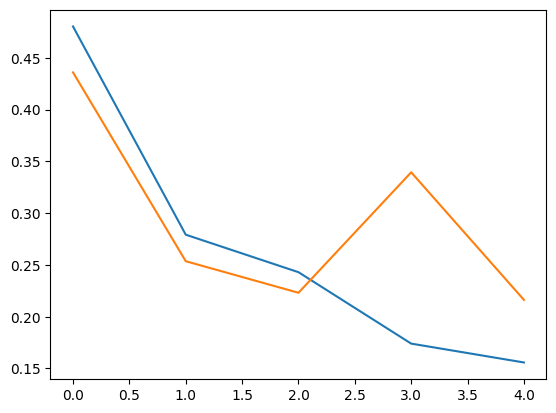

Epoch: 6
Train...


100%|██████████| 125/125 [00:09<00:00, 13.37it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 39.70it/s]

tensor(0.7961, device='cuda:0')
tensor(0.7777, device='cuda:0')
tensor(0.7275, device='cuda:0')
tensor(0.7825, device='cuda:0')
tensor(0.6319, device='cuda:0')
tensor(0.7123, device='cuda:0')
tensor(0.7866, device='cuda:0')
tensor(0.5786, device='cuda:0')


 26%|██▌       | 13/50 [00:00<00:00, 39.33it/s]

tensor(0.7294, device='cuda:0')
tensor(0.6856, device='cuda:0')
tensor(0.7077, device='cuda:0')
tensor(0.5181, device='cuda:0')
tensor(0.4225, device='cuda:0')
tensor(0.3602, device='cuda:0')
tensor(0.4076, device='cuda:0')
tensor(0.4516, device='cuda:0')
tensor(0.7279, device='cuda:0')


 44%|████▍     | 22/50 [00:00<00:00, 39.51it/s]

tensor(0.7572, device='cuda:0')
tensor(0.6238, device='cuda:0')
tensor(0.5849, device='cuda:0')
tensor(0.8667, device='cuda:0')
tensor(0.9138, device='cuda:0')
tensor(0.6848, device='cuda:0')
tensor(0.5746, device='cuda:0')
tensor(0.6644, device='cuda:0')


 60%|██████    | 30/50 [00:00<00:00, 39.65it/s]

tensor(0.8821, device='cuda:0')
tensor(0.8332, device='cuda:0')
tensor(0.8717, device='cuda:0')
tensor(0.8756, device='cuda:0')
tensor(0.6740, device='cuda:0')
tensor(0.7754, device='cuda:0')
tensor(0.8350, device='cuda:0')


 68%|██████▊   | 34/50 [00:00<00:00, 39.73it/s]

tensor(0.7936, device='cuda:0')
tensor(0.8072, device='cuda:0')


 76%|███████▌  | 38/50 [00:00<00:00, 39.70it/s]

tensor(0.7609, device='cuda:0')
tensor(0.7906, device='cuda:0')
tensor(0.9028, device='cuda:0')
tensor(0.4576, device='cuda:0')
tensor(0.5742, device='cuda:0')
tensor(0.4717, device='cuda:0')


 84%|████████▍ | 42/50 [00:01<00:00, 39.65it/s]

tensor(0.8146, device='cuda:0')
tensor(0.8137, device='cuda:0')


 94%|█████████▍| 47/50 [00:01<00:00, 39.85it/s]

tensor(0.8486, device='cuda:0')
tensor(0.9119, device='cuda:0')
tensor(0.6982, device='cuda:0')
tensor(0.7913, device='cuda:0')
tensor(0.7431, device='cuda:0')
tensor(0.9141, device='cuda:0')
tensor(0.9343, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.60it/s]

tensor(0.9184, device='cuda:0')
Mean IoU: 0.7234
Valid loss improved from 0.2163 to 0.1334. Saving checkpoint: ./best.pth


	Train Loss: 0.123
	 Val. Loss: 0.133



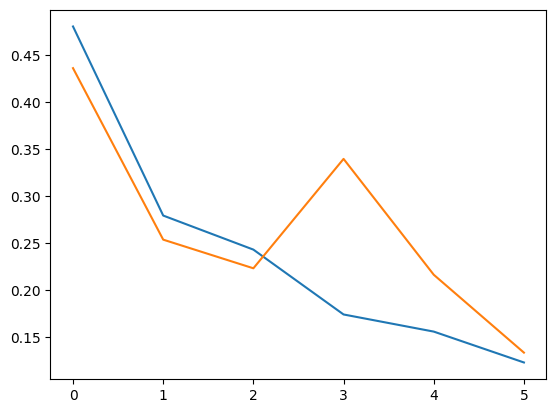

Epoch: 7
Train...


100%|██████████| 125/125 [00:09<00:00, 13.35it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.46it/s]

tensor(0.7969, device='cuda:0')
tensor(0.7786, device='cuda:0')
tensor(0.7264, device='cuda:0')
tensor(0.7842, device='cuda:0')
tensor(0.6326, device='cuda:0')
tensor(0.7124, device='cuda:0')
tensor(0.7883, device='cuda:0')
tensor(0.5798, device='cuda:0')
tensor(0.7307, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 39.84it/s]

tensor(0.6863, device='cuda:0')
tensor(0.7083, device='cuda:0')
tensor(0.5181, device='cuda:0')
tensor(0.4226, device='cuda:0')
tensor(0.3606, device='cuda:0')
tensor(0.4125, device='cuda:0')
tensor(0.4697, device='cuda:0')
tensor(0.7530, device='cuda:0')


 46%|████▌     | 23/50 [00:00<00:00, 39.84it/s]

tensor(0.7589, device='cuda:0')
tensor(0.6259, device='cuda:0')
tensor(0.5846, device='cuda:0')
tensor(0.8719, device='cuda:0')
tensor(0.9130, device='cuda:0')
tensor(0.6852, device='cuda:0')
tensor(0.5740, device='cuda:0')
tensor(0.6639, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 39.78it/s]

tensor(0.8809, device='cuda:0')
tensor(0.8315, device='cuda:0')
tensor(0.8815, device='cuda:0')
tensor(0.8738, device='cuda:0')
tensor(0.6751, device='cuda:0')
tensor(0.7755, device='cuda:0')
tensor(0.8513, device='cuda:0')
tensor(0.8002, device='cuda:0')


 82%|████████▏ | 41/50 [00:01<00:00, 39.89it/s]

tensor(0.8064, device='cuda:0')
tensor(0.7606, device='cuda:0')
tensor(0.7909, device='cuda:0')
tensor(0.9029, device='cuda:0')
tensor(0.4728, device='cuda:0')
tensor(0.5714, device='cuda:0')
tensor(0.4975, device='cuda:0')
tensor(0.8156, device='cuda:0')


 98%|█████████▊| 49/50 [00:01<00:00, 39.88it/s]

tensor(0.8157, device='cuda:0')
tensor(0.8487, device='cuda:0')
tensor(0.9085, device='cuda:0')
tensor(0.8519, device='cuda:0')
tensor(0.9215, device='cuda:0')
tensor(0.7706, device='cuda:0')
tensor(0.9354, device='cuda:0')
tensor(0.9344, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.81it/s]


tensor(0.9195, device='cuda:0')
Mean IoU: 0.7327
Valid loss improved from 0.1334 to 0.1093. Saving checkpoint: ./best.pth
	Train Loss: 0.103
	 Val. Loss: 0.109



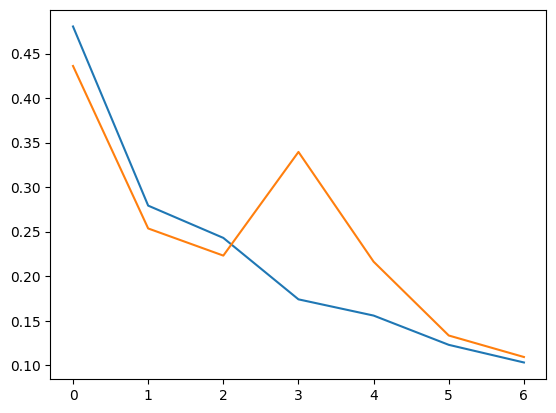

Epoch: 8
Train...


100%|██████████| 125/125 [00:09<00:00, 13.34it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 39.54it/s]

tensor(0.7970, device='cuda:0')
tensor(0.7751, device='cuda:0')
tensor(0.7258, device='cuda:0')
tensor(0.7869, device='cuda:0')
tensor(0.6340, device='cuda:0')
tensor(0.7120, device='cuda:0')
tensor(0.7861, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 39.77it/s]

tensor(0.5789, device='cuda:0')
tensor(0.7163, device='cuda:0')


 24%|██▍       | 12/50 [00:00<00:00, 39.86it/s]

tensor(0.6844, device='cuda:0')
tensor(0.7072, device='cuda:0')
tensor(0.5066, device='cuda:0')
tensor(0.4203, device='cuda:0')
tensor(0.3563, device='cuda:0')
tensor(0.4064, device='cuda:0')


 32%|███▏      | 16/50 [00:00<00:00, 39.50it/s]

tensor(0.4697, device='cuda:0')
tensor(0.7268, device='cuda:0')


 40%|████      | 20/50 [00:00<00:00, 39.52it/s]

tensor(0.7582, device='cuda:0')
tensor(0.6240, device='cuda:0')
tensor(0.5849, device='cuda:0')
tensor(0.8718, device='cuda:0')
tensor(0.9139, device='cuda:0')
tensor(0.6844, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 39.40it/s]

tensor(0.5740, device='cuda:0')
tensor(0.6619, device='cuda:0')


 56%|█████▌    | 28/50 [00:00<00:00, 39.46it/s]

tensor(0.8817, device='cuda:0')
tensor(0.8340, device='cuda:0')
tensor(0.8801, device='cuda:0')
tensor(0.8725, device='cuda:0')
tensor(0.6740, device='cuda:0')
tensor(0.7760, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 39.50it/s]

tensor(0.8475, device='cuda:0')
tensor(0.7895, device='cuda:0')


 72%|███████▏  | 36/50 [00:00<00:00, 39.42it/s]

tensor(0.8069, device='cuda:0')
tensor(0.7615, device='cuda:0')
tensor(0.7924, device='cuda:0')
tensor(0.9023, device='cuda:0')
tensor(0.4547, device='cuda:0')
tensor(0.5801, device='cuda:0')


 80%|████████  | 40/50 [00:01<00:00, 39.55it/s]

tensor(0.4847, device='cuda:0')
tensor(0.8141, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 39.63it/s]

tensor(0.7799, device='cuda:0')
tensor(0.8448, device='cuda:0')
tensor(0.9124, device='cuda:0')
tensor(0.8099, device='cuda:0')
tensor(0.8395, device='cuda:0')
tensor(0.6971, device='cuda:0')


 96%|█████████▌| 48/50 [00:01<00:00, 39.51it/s]

tensor(0.9363, device='cuda:0')
tensor(0.9078, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.55it/s]


tensor(0.9176, device='cuda:0')
Mean IoU: 0.7252
	Train Loss: 0.088
	 Val. Loss: 0.114



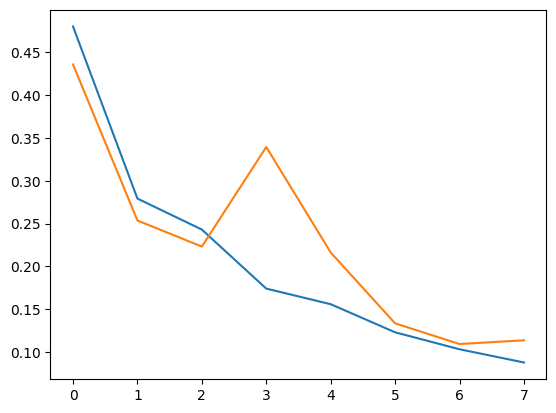

Epoch: 9
Train...


100%|██████████| 125/125 [00:09<00:00, 13.28it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.05it/s]

tensor(0.7964, device='cuda:0')
tensor(0.7785, device='cuda:0')
tensor(0.7276, device='cuda:0')
tensor(0.7841, device='cuda:0')
tensor(0.6339, device='cuda:0')
tensor(0.7126, device='cuda:0')
tensor(0.7890, device='cuda:0')
tensor(0.5793, device='cuda:0')
tensor(0.7304, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 39.84it/s]

tensor(0.6866, device='cuda:0')
tensor(0.7091, device='cuda:0')
tensor(0.5195, device='cuda:0')
tensor(0.4230, device='cuda:0')
tensor(0.3611, device='cuda:0')
tensor(0.4127, device='cuda:0')
tensor(0.4696, device='cuda:0')
tensor(0.7287, device='cuda:0')


 44%|████▍     | 22/50 [00:00<00:00, 39.78it/s]

tensor(0.7588, device='cuda:0')
tensor(0.6259, device='cuda:0')
tensor(0.5851, device='cuda:0')
tensor(0.8724, device='cuda:0')
tensor(0.9133, device='cuda:0')
tensor(0.6855, device='cuda:0')
tensor(0.5752, device='cuda:0')
tensor(0.6642, device='cuda:0')


 60%|██████    | 30/50 [00:00<00:00, 39.75it/s]

tensor(0.8824, device='cuda:0')
tensor(0.8319, device='cuda:0')
tensor(0.8803, device='cuda:0')
tensor(0.8742, device='cuda:0')
tensor(0.6745, device='cuda:0')
tensor(0.7769, device='cuda:0')
tensor(0.8510, device='cuda:0')
tensor(0.7971, device='cuda:0')


 76%|███████▌  | 38/50 [00:00<00:00, 39.59it/s]

tensor(0.8059, device='cuda:0')
tensor(0.7598, device='cuda:0')
tensor(0.7919, device='cuda:0')
tensor(0.9022, device='cuda:0')
tensor(0.4566, device='cuda:0')
tensor(0.5768, device='cuda:0')
tensor(0.4982, device='cuda:0')
tensor(0.8157, device='cuda:0')


 92%|█████████▏| 46/50 [00:01<00:00, 39.73it/s]

tensor(0.8168, device='cuda:0')
tensor(0.8417, device='cuda:0')
tensor(0.9125, device='cuda:0')
tensor(0.8557, device='cuda:0')
tensor(0.9203, device='cuda:0')
tensor(0.7753, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.76it/s]

tensor(0.9191, device='cuda:0')
tensor(0.9309, device='cuda:0')
tensor(0.9191, device='cuda:0')


Mean IoU: 0.7318
Valid loss improved from 0.1093 to 0.0793. Saving checkpoint: ./best.pth
	Train Loss: 0.075
	 Val. Loss: 0.079



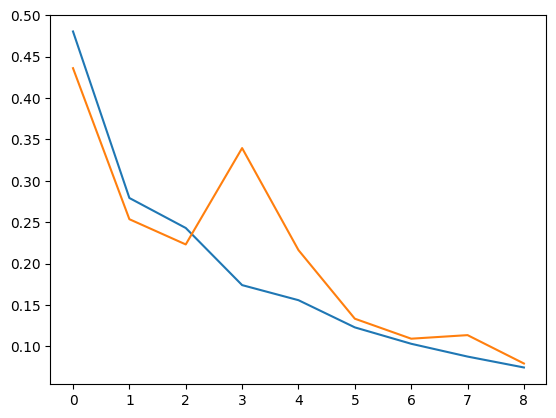

Epoch: 10
Train...


100%|██████████| 125/125 [00:09<00:00, 13.26it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.69it/s]

tensor(0.7975, device='cuda:0')
tensor(0.7795, device='cuda:0')
tensor(0.7286, device='cuda:0')
tensor(0.7849, device='cuda:0')
tensor(0.6335, device='cuda:0')
tensor(0.7128, device='cuda:0')
tensor(0.7890, device='cuda:0')
tensor(0.5799, device='cuda:0')
tensor(0.7308, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 39.88it/s]

tensor(0.6871, device='cuda:0')
tensor(0.7092, device='cuda:0')
tensor(0.5188, device='cuda:0')
tensor(0.4229, device='cuda:0')
tensor(0.3611, device='cuda:0')
tensor(0.4128, device='cuda:0')
tensor(0.4716, device='cuda:0')
tensor(0.7287, device='cuda:0')


 44%|████▍     | 22/50 [00:00<00:00, 39.66it/s]

tensor(0.7588, device='cuda:0')
tensor(0.6258, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.8723, device='cuda:0')
tensor(0.9141, device='cuda:0')
tensor(0.6846, device='cuda:0')
tensor(0.5752, device='cuda:0')
tensor(0.6640, device='cuda:0')


 60%|██████    | 30/50 [00:00<00:00, 39.65it/s]

tensor(0.8813, device='cuda:0')
tensor(0.8342, device='cuda:0')
tensor(0.8806, device='cuda:0')
tensor(0.8749, device='cuda:0')
tensor(0.6763, device='cuda:0')
tensor(0.7783, device='cuda:0')
tensor(0.8500, device='cuda:0')
tensor(0.7957, device='cuda:0')


 76%|███████▌  | 38/50 [00:00<00:00, 39.59it/s]

tensor(0.8062, device='cuda:0')
tensor(0.7609, device='cuda:0')
tensor(0.7906, device='cuda:0')
tensor(0.9049, device='cuda:0')
tensor(0.4568, device='cuda:0')
tensor(0.5768, device='cuda:0')
tensor(0.4961, device='cuda:0')
tensor(0.8160, device='cuda:0')


 92%|█████████▏| 46/50 [00:01<00:00, 39.41it/s]

tensor(0.8163, device='cuda:0')
tensor(0.8485, device='cuda:0')
tensor(0.9106, device='cuda:0')
tensor(0.8541, device='cuda:0')
tensor(0.9210, device='cuda:0')
tensor(0.7752, device='cuda:0')
tensor(0.9309, device='cuda:0')
tensor(0.9352, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.58it/s]


tensor(0.9191, device='cuda:0')
Mean IoU: 0.7324
Valid loss improved from 0.0793 to 0.0669. Saving checkpoint: ./best.pth
	Train Loss: 0.059
	 Val. Loss: 0.067



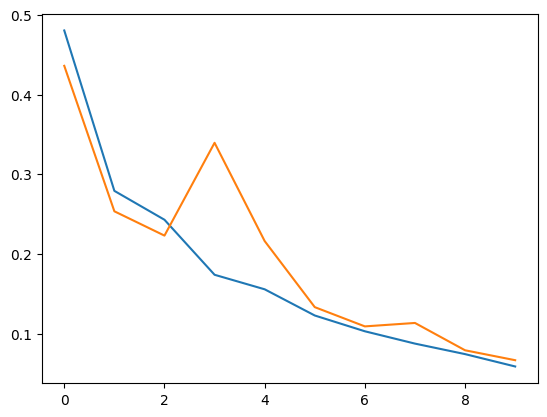

Epoch: 11
Train...


100%|██████████| 125/125 [00:09<00:00, 13.21it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 38.91it/s]

tensor(0.7977, device='cuda:0')
tensor(0.7795, device='cuda:0')
tensor(0.7290, device='cuda:0')
tensor(0.7852, device='cuda:0')
tensor(0.6342, device='cuda:0')
tensor(0.7131, device='cuda:0')
tensor(0.7893, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 38.76it/s]

tensor(0.5803, device='cuda:0')


 24%|██▍       | 12/50 [00:00<00:00, 38.88it/s]

tensor(0.7306, device='cuda:0')
tensor(0.6870, device='cuda:0')
tensor(0.7097, device='cuda:0')
tensor(0.5186, device='cuda:0')
tensor(0.4233, device='cuda:0')
tensor(0.3619, device='cuda:0')
tensor(0.4128, device='cuda:0')


 32%|███▏      | 16/50 [00:00<00:00, 39.04it/s]

tensor(0.4715, device='cuda:0')


 40%|████      | 20/50 [00:00<00:00, 39.19it/s]

tensor(0.7295, device='cuda:0')
tensor(0.7587, device='cuda:0')
tensor(0.6264, device='cuda:0')
tensor(0.5851, device='cuda:0')
tensor(0.8730, device='cuda:0')
tensor(0.9140, device='cuda:0')
tensor(0.6857, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 39.24it/s]

tensor(0.5757, device='cuda:0')


 56%|█████▌    | 28/50 [00:00<00:00, 39.26it/s]

tensor(0.6649, device='cuda:0')
tensor(0.8823, device='cuda:0')
tensor(0.8341, device='cuda:0')
tensor(0.8814, device='cuda:0')
tensor(0.8745, device='cuda:0')
tensor(0.6754, device='cuda:0')
tensor(0.7779, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 39.32it/s]

tensor(0.8509, device='cuda:0')


 72%|███████▏  | 36/50 [00:00<00:00, 39.34it/s]

tensor(0.7975, device='cuda:0')
tensor(0.8065, device='cuda:0')
tensor(0.7614, device='cuda:0')
tensor(0.7922, device='cuda:0')
tensor(0.9047, device='cuda:0')
tensor(0.4568, device='cuda:0')
tensor(0.5771, device='cuda:0')


 80%|████████  | 40/50 [00:01<00:00, 39.34it/s]

tensor(0.4958, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 39.27it/s]

tensor(0.8088, device='cuda:0')
tensor(0.8152, device='cuda:0')
tensor(0.8486, device='cuda:0')
tensor(0.9125, device='cuda:0')
tensor(0.8545, device='cuda:0')
tensor(0.9225, device='cuda:0')
tensor(0.7866, device='cuda:0')


 96%|█████████▌| 48/50 [00:01<00:00, 39.31it/s]

tensor(0.9367, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.22it/s]


tensor(0.9357, device='cuda:0')
tensor(0.9194, device='cuda:0')
Mean IoU: 0.7329
Valid loss improved from 0.0669 to 0.0574. Saving checkpoint: ./best.pth
	Train Loss: 0.052
	 Val. Loss: 0.057



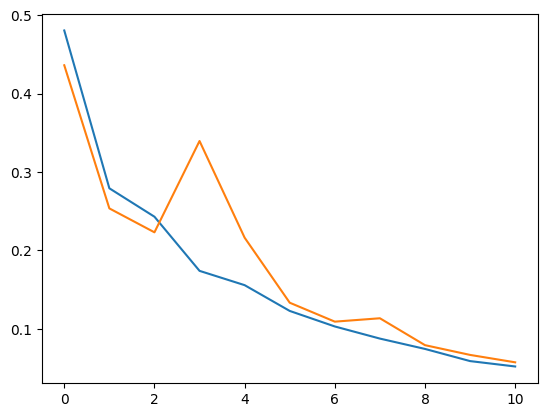

Epoch: 12
Train...


100%|██████████| 125/125 [00:09<00:00, 13.21it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.27it/s]

tensor(0.7977, device='cuda:0')
tensor(0.7776, device='cuda:0')
tensor(0.7285, device='cuda:0')
tensor(0.7851, device='cuda:0')
tensor(0.6334, device='cuda:0')
tensor(0.7124, device='cuda:0')
tensor(0.7888, device='cuda:0')
tensor(0.5801, device='cuda:0')
tensor(0.7307, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 39.56it/s]

tensor(0.6868, device='cuda:0')
tensor(0.7093, device='cuda:0')
tensor(0.5186, device='cuda:0')
tensor(0.4232, device='cuda:0')
tensor(0.3610, device='cuda:0')
tensor(0.4133, device='cuda:0')
tensor(0.4719, device='cuda:0')
tensor(0.7287, device='cuda:0')


 44%|████▍     | 22/50 [00:00<00:00, 39.52it/s]

tensor(0.7584, device='cuda:0')
tensor(0.6245, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.8720, device='cuda:0')
tensor(0.9129, device='cuda:0')
tensor(0.6852, device='cuda:0')
tensor(0.5752, device='cuda:0')
tensor(0.6542, device='cuda:0')


 60%|██████    | 30/50 [00:00<00:00, 39.61it/s]

tensor(0.8807, device='cuda:0')
tensor(0.8326, device='cuda:0')
tensor(0.8833, device='cuda:0')
tensor(0.8014, device='cuda:0')
tensor(0.6744, device='cuda:0')
tensor(0.7768, device='cuda:0')
tensor(0.8499, device='cuda:0')
tensor(0.7835, device='cuda:0')


 78%|███████▊  | 39/50 [00:00<00:00, 39.72it/s]

tensor(0.8055, device='cuda:0')
tensor(0.7607, device='cuda:0')
tensor(0.7905, device='cuda:0')
tensor(0.9037, device='cuda:0')
tensor(0.4544, device='cuda:0')
tensor(0.5831, device='cuda:0')
tensor(0.4951, device='cuda:0')
tensor(0.8148, device='cuda:0')


 94%|█████████▍| 47/50 [00:01<00:00, 39.60it/s]

tensor(0.8172, device='cuda:0')
tensor(0.8440, device='cuda:0')
tensor(0.9130, device='cuda:0')
tensor(0.8549, device='cuda:0')
tensor(0.9209, device='cuda:0')
tensor(0.7988, device='cuda:0')
tensor(0.9342, device='cuda:0')
tensor(0.9346, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.58it/s]


tensor(0.9189, device='cuda:0')
Mean IoU: 0.7308
	Train Loss: 0.048
	 Val. Loss: 0.064



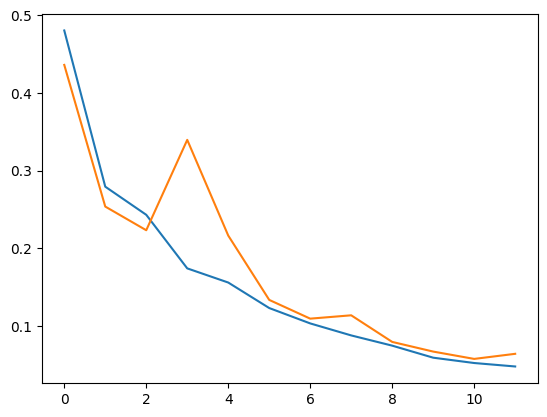

Epoch: 13
Train...


100%|██████████| 125/125 [00:09<00:00, 13.10it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 37.66it/s]

tensor(0.7951, device='cuda:0')
tensor(0.7778, device='cuda:0')
tensor(0.7293, device='cuda:0')
tensor(0.7840, device='cuda:0')
tensor(0.6353, device='cuda:0')
tensor(0.7136, device='cuda:0')
tensor(0.7896, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 36.48it/s]

tensor(0.5813, device='cuda:0')


 24%|██▍       | 12/50 [00:00<00:01, 37.30it/s]

tensor(0.7273, device='cuda:0')
tensor(0.6872, device='cuda:0')
tensor(0.7092, device='cuda:0')
tensor(0.5185, device='cuda:0')
tensor(0.3586, device='cuda:0')
tensor(0.3624, device='cuda:0')
tensor(0.4126, device='cuda:0')


 32%|███▏      | 16/50 [00:00<00:00, 37.27it/s]

tensor(0.4699, device='cuda:0')


 40%|████      | 20/50 [00:00<00:00, 37.56it/s]

tensor(0.7290, device='cuda:0')
tensor(0.7592, device='cuda:0')
tensor(0.6265, device='cuda:0')
tensor(0.5844, device='cuda:0')
tensor(0.8729, device='cuda:0')
tensor(0.9137, device='cuda:0')
tensor(0.6861, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 37.69it/s]

tensor(0.5769, device='cuda:0')


 56%|█████▌    | 28/50 [00:00<00:00, 37.86it/s]

tensor(0.6653, device='cuda:0')
tensor(0.8787, device='cuda:0')
tensor(0.8329, device='cuda:0')
tensor(0.8803, device='cuda:0')
tensor(0.8752, device='cuda:0')
tensor(0.6747, device='cuda:0')
tensor(0.7727, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 38.16it/s]

tensor(0.8435, device='cuda:0')


 72%|███████▏  | 36/50 [00:00<00:00, 38.31it/s]

tensor(0.7967, device='cuda:0')
tensor(0.7944, device='cuda:0')
tensor(0.7611, device='cuda:0')
tensor(0.7927, device='cuda:0')
tensor(0.9027, device='cuda:0')
tensor(0.4614, device='cuda:0')
tensor(0.5769, device='cuda:0')


 80%|████████  | 40/50 [00:01<00:00, 38.49it/s]

tensor(0.4864, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 38.45it/s]

tensor(0.7987, device='cuda:0')
tensor(0.8177, device='cuda:0')
tensor(0.8059, device='cuda:0')
tensor(0.8528, device='cuda:0')
tensor(0.8113, device='cuda:0')
tensor(0.9100, device='cuda:0')
tensor(0.7053, device='cuda:0')


 96%|█████████▌| 48/50 [00:01<00:00, 38.77it/s]

tensor(0.6844, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 38.12it/s]


tensor(0.9345, device='cuda:0')
tensor(0.5867, device='cuda:0')
Mean IoU: 0.7141
	Train Loss: 0.058
	 Val. Loss: 0.129



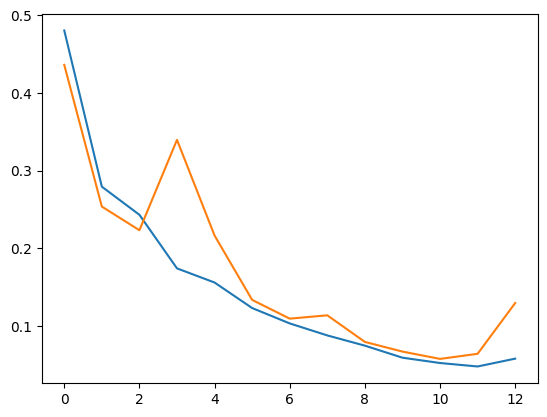

Epoch: 14
Train...


100%|██████████| 125/125 [00:09<00:00, 13.09it/s]


Valid...


 10%|█         | 5/50 [00:00<00:01, 40.06it/s]

tensor(0.7964, device='cuda:0')
tensor(0.7789, device='cuda:0')
tensor(0.7291, device='cuda:0')
tensor(0.7838, device='cuda:0')
tensor(0.6341, device='cuda:0')
tensor(0.7128, device='cuda:0')
tensor(0.7893, device='cuda:0')
tensor(0.5806, device='cuda:0')
tensor(0.7296, device='cuda:0')


 28%|██▊       | 14/50 [00:00<00:00, 39.75it/s]

tensor(0.6862, device='cuda:0')
tensor(0.7098, device='cuda:0')
tensor(0.5184, device='cuda:0')
tensor(0.4229, device='cuda:0')
tensor(0.3612, device='cuda:0')
tensor(0.4116, device='cuda:0')
tensor(0.4456, device='cuda:0')
tensor(0.7287, device='cuda:0')


 44%|████▍     | 22/50 [00:00<00:00, 39.45it/s]

tensor(0.7574, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.5856, device='cuda:0')
tensor(0.8727, device='cuda:0')
tensor(0.9135, device='cuda:0')
tensor(0.6912, device='cuda:0')
tensor(0.5746, device='cuda:0')
tensor(0.6644, device='cuda:0')


 60%|██████    | 30/50 [00:00<00:00, 39.56it/s]

tensor(0.8803, device='cuda:0')
tensor(0.8341, device='cuda:0')
tensor(0.8809, device='cuda:0')
tensor(0.8746, device='cuda:0')
tensor(0.6729, device='cuda:0')
tensor(0.7767, device='cuda:0')
tensor(0.8482, device='cuda:0')
tensor(0.7968, device='cuda:0')


 78%|███████▊  | 39/50 [00:00<00:00, 39.70it/s]

tensor(0.8079, device='cuda:0')
tensor(0.7612, device='cuda:0')
tensor(0.7906, device='cuda:0')
tensor(0.8927, device='cuda:0')
tensor(0.4644, device='cuda:0')
tensor(0.5768, device='cuda:0')
tensor(0.4941, device='cuda:0')
tensor(0.8088, device='cuda:0')


 94%|█████████▍| 47/50 [00:01<00:00, 39.60it/s]

tensor(0.8156, device='cuda:0')
tensor(0.8481, device='cuda:0')
tensor(0.9126, device='cuda:0')
tensor(0.7752, device='cuda:0')
tensor(0.9212, device='cuda:0')
tensor(0.7708, device='cuda:0')
tensor(0.8116, device='cuda:0')
tensor(0.8833, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.54it/s]


tensor(0.9197, device='cuda:0')
Mean IoU: 0.7264
	Train Loss: 0.063
	 Val. Loss: 0.078



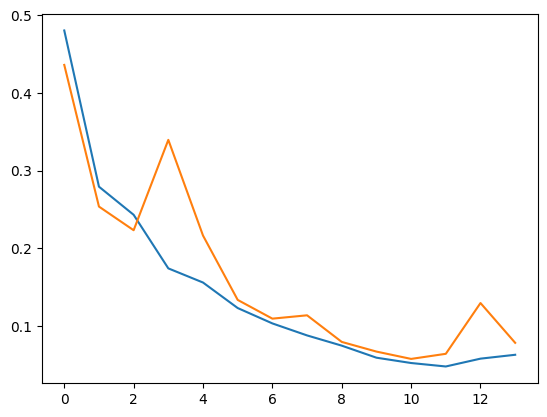

Epoch: 15
Train...


100%|██████████| 125/125 [00:09<00:00, 13.13it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 39.45it/s]

tensor(0.7973, device='cuda:0')
tensor(0.7789, device='cuda:0')
tensor(0.7282, device='cuda:0')
tensor(0.7837, device='cuda:0')
tensor(0.6331, device='cuda:0')
tensor(0.7125, device='cuda:0')
tensor(0.7887, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 38.46it/s]

tensor(0.5798, device='cuda:0')


 24%|██▍       | 12/50 [00:00<00:00, 38.80it/s]

tensor(0.7296, device='cuda:0')
tensor(0.6867, device='cuda:0')
tensor(0.7090, device='cuda:0')
tensor(0.5193, device='cuda:0')
tensor(0.4233, device='cuda:0')
tensor(0.3614, device='cuda:0')
tensor(0.4117, device='cuda:0')


 32%|███▏      | 16/50 [00:00<00:00, 39.21it/s]

tensor(0.4706, device='cuda:0')


 40%|████      | 20/50 [00:00<00:00, 39.37it/s]

tensor(0.7292, device='cuda:0')
tensor(0.7584, device='cuda:0')
tensor(0.6253, device='cuda:0')
tensor(0.5845, device='cuda:0')
tensor(0.8717, device='cuda:0')
tensor(0.9138, device='cuda:0')
tensor(0.6854, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 39.33it/s]

tensor(0.5753, device='cuda:0')


 56%|█████▌    | 28/50 [00:00<00:00, 39.31it/s]

tensor(0.6646, device='cuda:0')
tensor(0.8809, device='cuda:0')
tensor(0.8341, device='cuda:0')
tensor(0.8823, device='cuda:0')
tensor(0.8737, device='cuda:0')
tensor(0.6745, device='cuda:0')
tensor(0.7770, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 39.36it/s]

tensor(0.8514, device='cuda:0')


 72%|███████▏  | 36/50 [00:00<00:00, 39.07it/s]

tensor(0.7964, device='cuda:0')
tensor(0.7992, device='cuda:0')
tensor(0.7614, device='cuda:0')
tensor(0.7916, device='cuda:0')
tensor(0.9052, device='cuda:0')
tensor(0.4572, device='cuda:0')
tensor(0.5738, device='cuda:0')


 80%|████████  | 40/50 [00:01<00:00, 38.91it/s]

tensor(0.4956, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 38.98it/s]

tensor(0.8133, device='cuda:0')
tensor(0.8176, device='cuda:0')
tensor(0.8479, device='cuda:0')
tensor(0.9124, device='cuda:0')
tensor(0.8528, device='cuda:0')
tensor(0.9204, device='cuda:0')
tensor(0.7747, device='cuda:0')


 96%|█████████▌| 48/50 [00:01<00:00, 39.13it/s]

tensor(0.9189, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.08it/s]


tensor(0.9351, device='cuda:0')
tensor(0.9184, device='cuda:0')
Mean IoU: 0.7318
Valid loss improved from 0.0574 to 0.0484. Saving checkpoint: ./best.pth
	Train Loss: 0.045
	 Val. Loss: 0.048



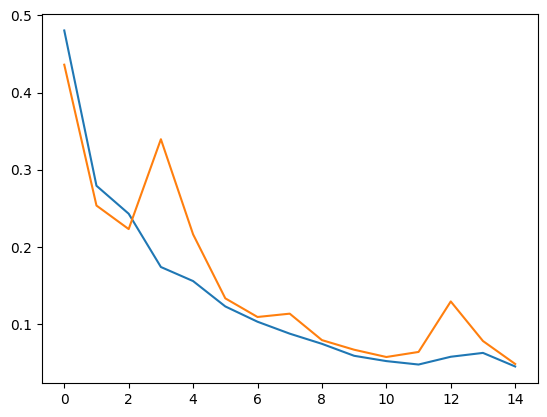

Epoch: 16
Train...


100%|██████████| 125/125 [00:09<00:00, 13.09it/s]


Valid...


  8%|▊         | 4/50 [00:00<00:01, 39.58it/s]

tensor(0.7977, device='cuda:0')
tensor(0.7791, device='cuda:0')
tensor(0.7286, device='cuda:0')
tensor(0.7849, device='cuda:0')
tensor(0.6336, device='cuda:0')
tensor(0.7127, device='cuda:0')
tensor(0.7893, device='cuda:0')


 16%|█▌        | 8/50 [00:00<00:01, 39.23it/s]

tensor(0.5803, device='cuda:0')


 24%|██▍       | 12/50 [00:00<00:00, 39.14it/s]

tensor(0.7308, device='cuda:0')
tensor(0.6868, device='cuda:0')
tensor(0.7094, device='cuda:0')
tensor(0.5194, device='cuda:0')
tensor(0.4234, device='cuda:0')
tensor(0.3624, device='cuda:0')
tensor(0.4132, device='cuda:0')


 32%|███▏      | 16/50 [00:00<00:00, 38.95it/s]

tensor(0.4709, device='cuda:0')


 40%|████      | 20/50 [00:00<00:00, 38.86it/s]

tensor(0.7280, device='cuda:0')
tensor(0.7588, device='cuda:0')
tensor(0.6262, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(0.8729, device='cuda:0')
tensor(0.9137, device='cuda:0')
tensor(0.6858, device='cuda:0')


 48%|████▊     | 24/50 [00:00<00:00, 38.92it/s]

tensor(0.5755, device='cuda:0')


 56%|█████▌    | 28/50 [00:00<00:00, 39.10it/s]

tensor(0.6646, device='cuda:0')
tensor(0.8812, device='cuda:0')
tensor(0.8339, device='cuda:0')
tensor(0.8815, device='cuda:0')
tensor(0.8745, device='cuda:0')
tensor(0.6747, device='cuda:0')
tensor(0.7779, device='cuda:0')


 64%|██████▍   | 32/50 [00:00<00:00, 39.15it/s]

tensor(0.8504, device='cuda:0')


 72%|███████▏  | 36/50 [00:00<00:00, 39.24it/s]

tensor(0.7951, device='cuda:0')
tensor(0.8063, device='cuda:0')
tensor(0.7610, device='cuda:0')
tensor(0.7910, device='cuda:0')
tensor(0.9049, device='cuda:0')
tensor(0.4565, device='cuda:0')
tensor(0.5781, device='cuda:0')


 80%|████████  | 40/50 [00:01<00:00, 39.09it/s]

tensor(0.4954, device='cuda:0')


 88%|████████▊ | 44/50 [00:01<00:00, 39.08it/s]

tensor(0.8164, device='cuda:0')
tensor(0.8165, device='cuda:0')
tensor(0.8473, device='cuda:0')
tensor(0.9130, device='cuda:0')
tensor(0.8540, device='cuda:0')
tensor(0.9204, device='cuda:0')
tensor(0.8109, device='cuda:0')


 96%|█████████▌| 48/50 [00:01<00:00, 39.12it/s]

tensor(0.9066, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 39.14it/s]


tensor(0.9354, device='cuda:0')
tensor(0.9187, device='cuda:0')
Mean IoU: 0.7327
Valid loss improved from 0.0484 to 0.0475. Saving checkpoint: ./best.pth
	Train Loss: 0.035
	 Val. Loss: 0.047



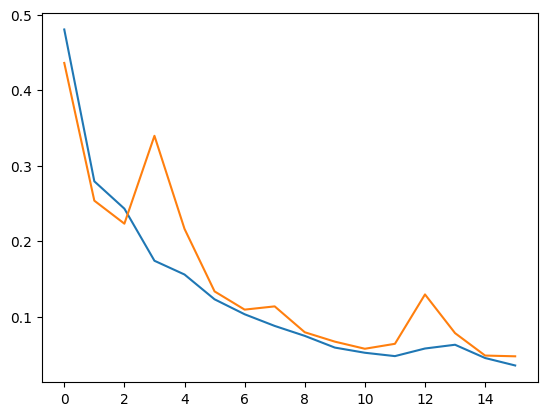

Epoch: 17
Train...


 83%|████████▎ | 104/125 [00:07<00:01, 13.06it/s]


KeyboardInterrupt: 

In [7]:

import os
import time
import numpy as np
from glob import glob
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm

def train(model, loader, optimizer, loss_fn, device):
    print("Train...")
    epoch_loss = 0.0

    
    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device, threshold = 0.6):
    print("Valid...")
    epoch_loss = 0.0

    iou_arr = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            iou = iou_pytorch(y_pred, y)

            iou_arr.append(iou.cpu().numpy())
        mean_iou = np.mean(iou_arr)
        print('Mean IoU: {:.4f}'.format(mean_iou))
        epoch_loss = epoch_loss/len(loader)
        
    return epoch_loss


if __name__ == "__main__":
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    '''
    Code Unet for ----------  2 CLASSES ----------
    '''

    seeding(1234)
    """ Load dataset """
    # train_x = sorted(glob("đường dẫn tới thư mục ảnh tập train/*")) # Lưu ý: Có dấu * phía cuối
    # train_y = sorted(glob("đường dẫn tới thư mục label tập train/*"))
    # valid_x = sorted(glob("đường dẫn tới thư mục ảnh train của tập test/*"))
    # valid_y = sorted(glob("đường dẫn tới thư mục label của tập test/*"))
    train_x = sorted(glob("dataset_full/dataset_full/train/*"))[:500] # Lưu ý: Có dấu * phía cuối
    train_y = sorted(glob("dataset_full/dataset_full/trainanot_full/*"))[:500]
    valid_x = sorted(glob("dataset_full/dataset_full/val/*"))[:200]
    valid_y = sorted(glob("dataset_full/dataset_full/valanot_full/*"))[:200]
    
    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 80
    W = 160
    size = (W, H)
    batch_size = 4
    num_epochs = 30
    lr = 1e-4
    checkpoint_path = "./best.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y, W, H)
    valid_dataset = DriveDataset(valid_x, valid_y, W, H)


    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    device = torch.device('cuda') 
    model = build_unet()
    model = model.to(device)

    torch.backends.cudnn.benchmark = True # new
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    loss_train_plt = []
    loss_val_plt = []

    for epoch in range(num_epochs):
        print("Epoch:", epoch+1)
        train_loss = train(model, train_loader, optimizer, loss_fn, device)    
        valid_loss = evaluate(model, valid_loader, loss_fn, device)
        
        """ Saving the model """
        if valid_loss < best_valid_loss:
            print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

            best_valid_loss = valid_loss
            name = os.path.join(os.getcwd(), "output_" + str(epoch) + ".pth")
            torch.save(model.state_dict(), name)

        print(f'\tTrain Loss: {train_loss:.3f}\n\t Val. Loss: {valid_loss:.3f}\n')
        
        loss_train_plt.append(train_loss)
        loss_val_plt.append(valid_loss)
        plt.plot(loss_train_plt)
        plt.plot(loss_val_plt)
        plt.show(f"loss_epoch_{epoch}.png")  

Test mô hình

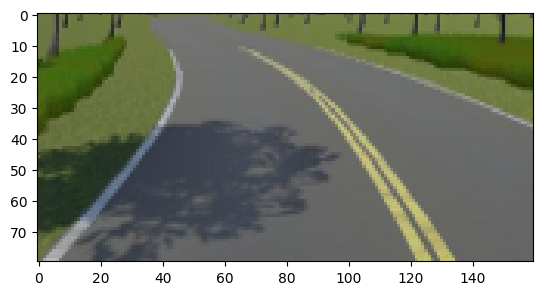

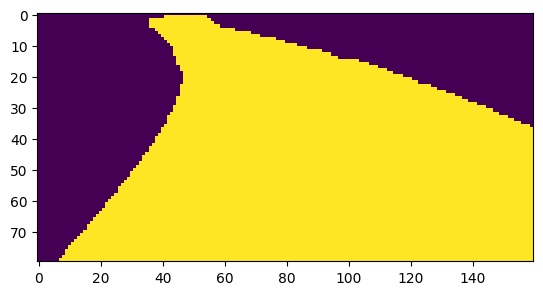

In [118]:
import cv2
import numpy as np
import torch
import time

checkpoint_path = "duong dan toi file .pth"
model = build_unet().cuda()
model.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))
model.eval()

# 159, 396
img = cv2.imread("noise_lane.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (160, 80))

x = torch.from_numpy(img).cuda()
x = x.transpose(1, 2).transpose(0, 1)
x = x / 255.0
x = x.unsqueeze(0).float()
with torch.no_grad():
    pred = model(x)
    pred = torch.sigmoid(pred)
    pred = pred[0].squeeze()
    pred = (pred > 0.5).cpu().numpy()

    pred = np.array(pred, dtype=np.uint8)
    pred = pred * 255


# cv2.imwrite("pred.png", cv2.resize(pred, (160, 80)))
plt.imshow(img)
plt.show()
plt.imshow(pred)
plt.show()
